###                 OffensEval Group Project

1. Ahmad Zubair, 19101147, 01
2. lasania, 19101144, 02
3. Aakar Dhakal, 20201203, 02








# Import/Install Required Libraries

In [ ]:
# If you Encounter any ModuleNotFound Error, run this cell just be safe

!pip install nltk
!pip install pandas
!pip install wordcloud
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install keras
!pip install tensorflow
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Exlporation, Preprocessing, and Visualization



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exlploration

In [ ]:
tweets = pd.read_table('/content/drive/MyDrive/Dataset/olid-training-v1.0.tsv', delimiter='\t')

test_inst_a = pd.read_table('/content/drive/MyDrive/Dataset/testset-levela.tsv', delimiter='\t')
test_inst_b = pd.read_table('/content/drive/MyDrive/Dataset/testset-levelb.tsv', delimiter='\t')
test_inst_c = pd.read_table('/content/drive/MyDrive/Dataset/testset-levelc.tsv', delimiter='\t')

test_label_a = pd.read_csv('/content/drive/MyDrive/Dataset/labels-levela.csv', header=None)
test_label_b = pd.read_csv('/content/drive/MyDrive/Dataset/labels-levelb.csv', header=None)
test_label_c = pd.read_csv('/content/drive/MyDrive/Dataset/labels-levelc.csv', header=None)

In [ ]:
tweets

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13240 non-null  int64 
 1   tweet      13240 non-null  object
 2   subtask_a  13240 non-null  object
 3   subtask_b  4400 non-null   object
 4   subtask_c  3876 non-null   object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


In [ ]:
tweets.isnull().sum()

id              0
tweet           0
subtask_a       0
subtask_b    8840
subtask_c    9364
dtype: int64

## Preprocessing

In [ ]:
def data_preprocessing(text):
    text = text.lower() #Set text to lowercase
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE) #Remove links from the text
    text = re.sub(r'url','',text) #Remove URL from text
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'\@w+|\#','',text) #Remove @ and # from the text
    text = re.sub(r'[^\w\s]','',text) #Remove non-alphanumeric characters
    text = re.sub(r'user','',text) #Remove USER from text
    text_tokens = nltk.word_tokenize(text) #Tokenization
    stop_words = set(stopwords.words('english'))
    remove_stop_words = [w for w in text_tokens if not w in stop_words] #Stop words removal
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in remove_stop_words] #Lemmatization

    processed_text = " ".join(lemmatized_words)

    return processed_text

In [ ]:
tweets.tweet = tweets['tweet'].apply(data_preprocessing)
processed_tweets = tweets

In [ ]:
tweets

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,ask native american take,OFF,UNT,NaN
1,90194,go home youre drunk maga trump2020,OFF,TIN,IND
2,16820,amazon investigating chinese employee selling ...,NOT,NaN,NaN
3,62688,someone shouldvetaken piece shit volcano,OFF,UNT,NaN
4,43605,obama wanted liberal illegals move red state,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,sometimes get strong vibe people man vibe ten ...,OFF,TIN,IND
13236,67210,benidorm creamfields maga shabby summer,NOT,NaN,NaN
13237,82921,report garbage dont give crap,OFF,TIN,OTH
13238,27429,pussy,OFF,UNT,NaN


## Visualization

<Figure size 1200x1200 with 0 Axes>

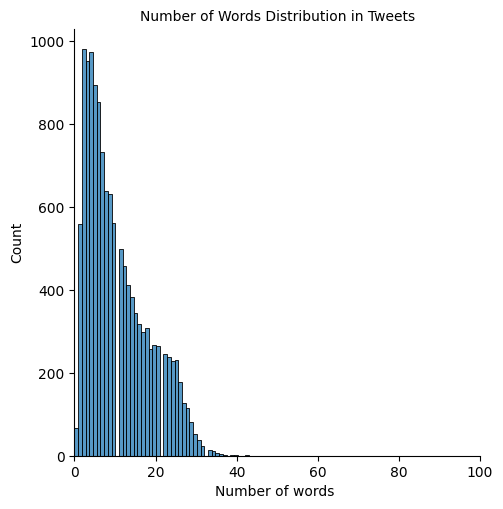

In [ ]:
tweets['count'] = tweets['tweet'].apply(lambda x: len(x.split()))
plt.figure(figsize= (12, 12))

sns.displot(tweets['count'])

plt.xlim(0, 100)

plt.xlabel('Number of words ', fontsize = 10)
plt.title("Number of Words Distribution in Tweets", fontsize = 10)
plt.show()

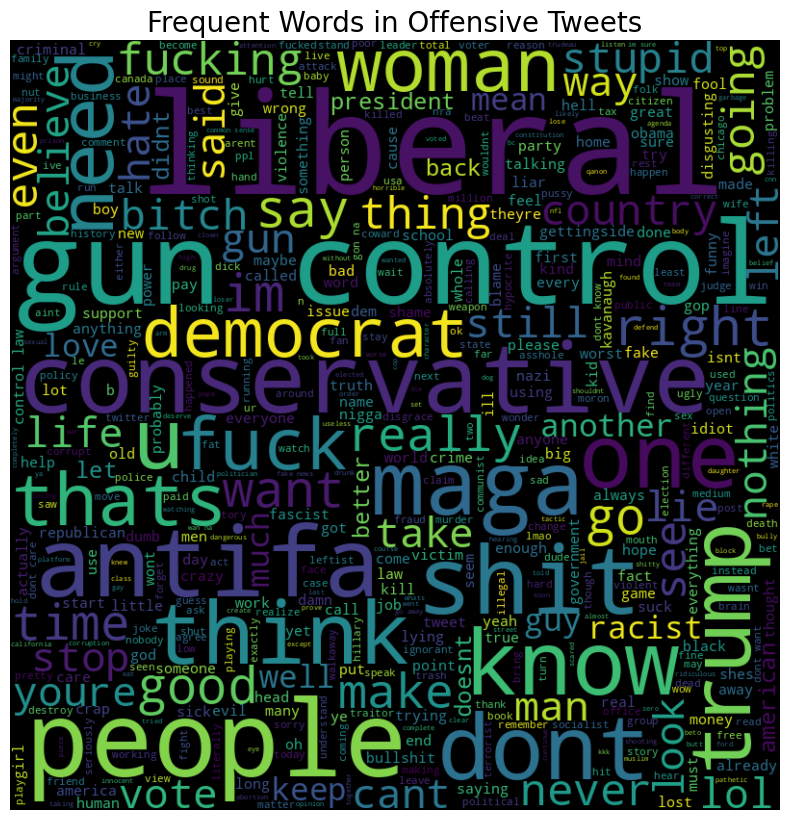

In [ ]:
tweets_sub_a = tweets[tweets['subtask_a'] == 'OFF']
text = ' '.join([word for word in tweets_sub_a['tweet']])
plt.figure(figsize=(10, 10), facecolor='None')
wordcloud = WordCloud(max_words=500, width=800, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Frequent Words in Offensive Tweets', fontsize=20)
plt.show()

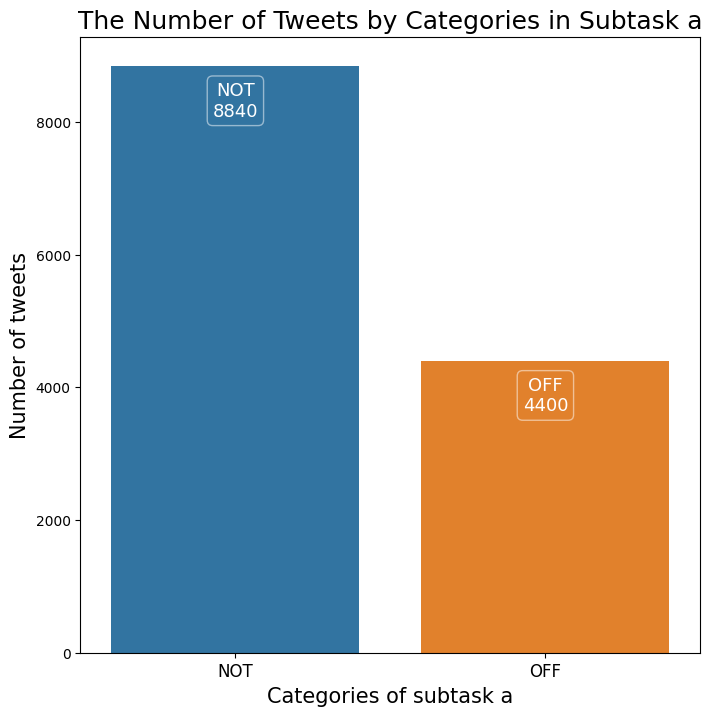

In [ ]:
category_count_a = tweets['subtask_a'].value_counts()
categories_a = category_count_a.index

fig = plt.figure(figsize= (8, 8))
ax = fig.add_subplot(111)
sns.barplot(x = category_count_a.index, y = category_count_a )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories_a[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories of subtask a', size = 15)
plt.ylabel('Number of tweets', size= 15)
plt.xticks(size = 12)
plt.title("The Number of Tweets by Categories in Subtask a" , size = 18)
plt.show()

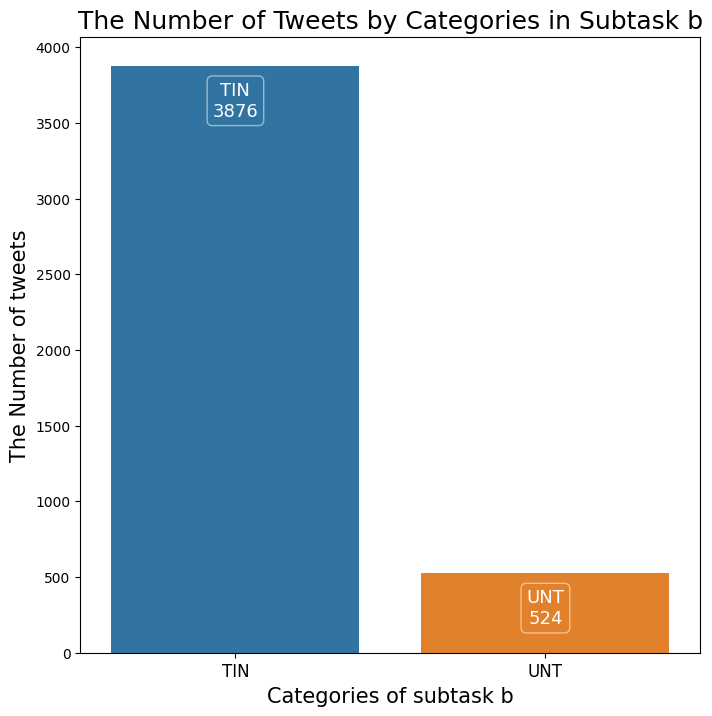

In [ ]:
cat_b = tweets.loc[tweets['subtask_b'].isin(['TIN', 'UNT']), 'subtask_b']
category_count_b = cat_b.value_counts()
categories_b = category_count_b.index

fig = plt.figure(figsize= (8, 8))
ax = fig.add_subplot(111)
sns.barplot(x = category_count_b.index, y = category_count_b )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories_b[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories of subtask b', size = 15)
plt.ylabel('The Number of tweets', size= 15)
plt.xticks(size = 12)
plt.title("The Number of Tweets by Categories in Subtask b" , size = 18)
plt.show()

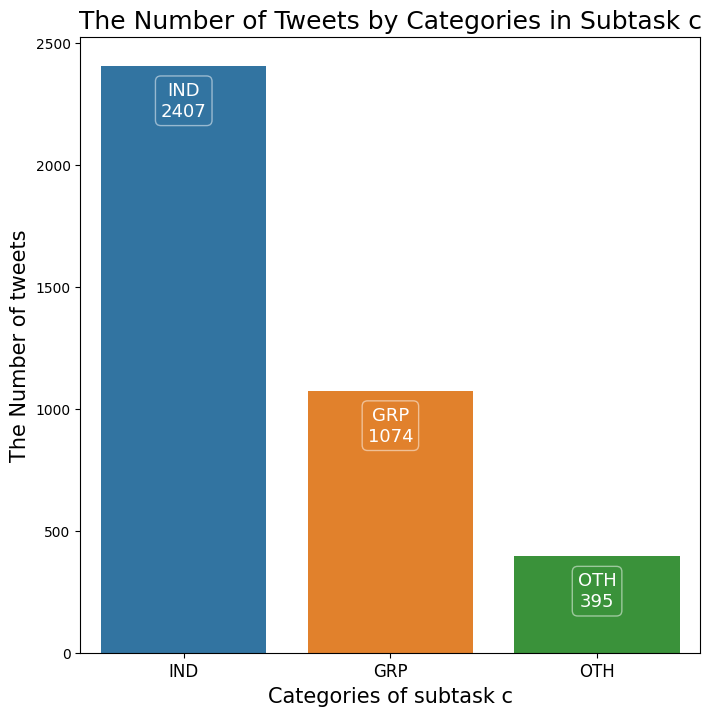

In [ ]:
cat_c = tweets.loc[tweets['subtask_c'].isin(['IND', 'GRP', 'OTH']), 'subtask_c']
category_count_c = cat_c.value_counts()
categories_c = category_count_c.index
fig = plt.figure(figsize= (8, 8))
ax = fig.add_subplot(111)
sns.barplot(x = category_count_c.index, y = category_count_c )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories_c[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories of subtask c', size = 15)
plt.ylabel('The Number of tweets', size= 15)
plt.xticks(size = 12)
plt.title("The Number of Tweets by Categories in Subtask c" , size = 18)
plt.show()

#LSTM

### Subtask a

#### Dataset

In [ ]:
tweets.loc[tweets['subtask_a'] == 'OFF', 'subtask_an'] = 1
tweets.loc[tweets['subtask_a'] == 'NOT', 'subtask_an'] = 0
tweets['subtask_an'] = tweets['subtask_an'].astype('int')

test_label_a.loc[test_label_a[1] == 'OFF', 'subtask_an'] = 1
test_label_a.loc[test_label_a[1] == 'NOT', 'subtask_an'] = 0
test_label_a['subtask_an'] = test_label_a['subtask_an'].astype('int')

test_label_a.head(10)

,0,1,subtask_an
0,15923,OFF,1
1,27014,NOT,0
2,30530,NOT,0
3,13876,NOT,0
4,60133,OFF,1
5,83681,OFF,1
6,96874,NOT,0
7,65507,OFF,1
8,78910,NOT,0
9,46363,NOT,0


In [ ]:
tweets_a = tweets['tweet'].to_list()
tweets_labels_a = tweets['subtask_an'].to_list()

test_a = test_inst_a['tweet'].to_list()
test_labels_a = test_label_a['subtask_an'].to_list()

In [ ]:
voc_size=1000
onehot_repr_train_a=[one_hot(t,voc_size)for t in tweets_a]
onehot_repr_test_a=[one_hot(t,voc_size)for t in test_a]

In [ ]:
sent_length=20
embedded_docs_train=pad_sequences(onehot_repr_train_a,padding='pre',maxlen=sent_length)
print(embedded_docs_train)

embedded_docs_test=pad_sequences(onehot_repr_test_a,padding='pre',maxlen=sent_length)
print(embedded_docs_test)

[[  0   0   0 ... 588 138 500]
 [  0   0   0 ... 554 419 620]
 [  0   0 210 ... 565 240 607]
 ...
 [  0   0   0 ... 566 623 901]
 [  0   0   0 ...   0   0 214]
 [  0   0   0 ... 843 293 580]]
[[941 253 488 ... 677 807  64]
 [  0   0   0 ... 983 364 179]
 [323 807 807 ...  91 601  64]
 ...
 [800 637 318 ... 476 100 574]
 [917 949 757 ... 757 625 658]
 [  0   0   0 ... 394 974  64]]


In [ ]:
X_a=np.array(embedded_docs_train)
Y_a=np.array(tweets_labels_a)

X_test_a=np.array(embedded_docs_test)
Y_test_a=np.array(test_labels_a)

#### Train-Test Split

In [ ]:
x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_a, Y_a, test_size=0.2, random_state=42)

#### Model Creation

In [ ]:

embedding_vector_features=40
model_a=Sequential()
model_a.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model_a.add(Dropout(0.3))
model_a.add(LSTM(100))
model_a.add(Dropout(0.3))
model_a.add(Dense(1,activation='sigmoid'))
model_a.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model_a.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            40000     
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 96,501
Trainable params: 96,501
Non-trainable params: 0
_________________________________________________________________
None


#### Model Training

In [ ]:
model_a.fit(x_train_a, y_train_a, validation_data=(x_val_a,y_val_a), epochs=10, batch_size=64)

Epoch 1/10
166/166 [==============================] - 58s 230ms/step - loss: 0.6183 - accuracy: 0.6740 - val_loss: 0.5994 - val_accuracy: 0.6816
Epoch 2/10
166/166 [==============================] - 11s 68ms/step - loss: 0.5544 - accuracy: 0.7237 - val_loss: 0.5842 - val_accuracy: 0.7020
Epoch 3/10
166/166 [==============================] - 6s 34ms/step - loss: 0.5332 - accuracy: 0.7343 - val_loss: 0.5857 - val_accuracy: 0.6975
Epoch 4/10
166/166 [==============================] - 3s 17ms/step - loss: 0.5247 - accuracy: 0.7447 - val_loss: 0.6016 - val_accuracy: 0.6994
Epoch 5/10
166/166 [==============================] - 4s 21ms/step - loss: 0.5188 - accuracy: 0.7449 - val_loss: 0.5899 - val_accuracy: 0.6945
Epoch 6/10
166/166 [==============================] - 6s 38ms/step - loss: 0.5092 - accuracy: 0.7520 - val_loss: 0.6090 - val_accuracy: 0.6900
Epoch 7/10
166/166 [==============================] - 3s 21ms/step - loss: 0.4978 - accuracy: 0.7589 - val_loss: 0.6180 - val_accuracy: 0.6

#### Model Testing

In [ ]:
y_pred=model_a.predict(X_test_a)

27/27 [==============================] - 1s 3ms/step


In [ ]:
# y_pred

In [ ]:
y_pred_binary_a = (y_pred > 0.5).astype(int)

#### Accuracy, Confusion Matrix and f1 Value

In [ ]:
accuracy_score(Y_test_a,y_pred_binary_a)

0.5267441860465116

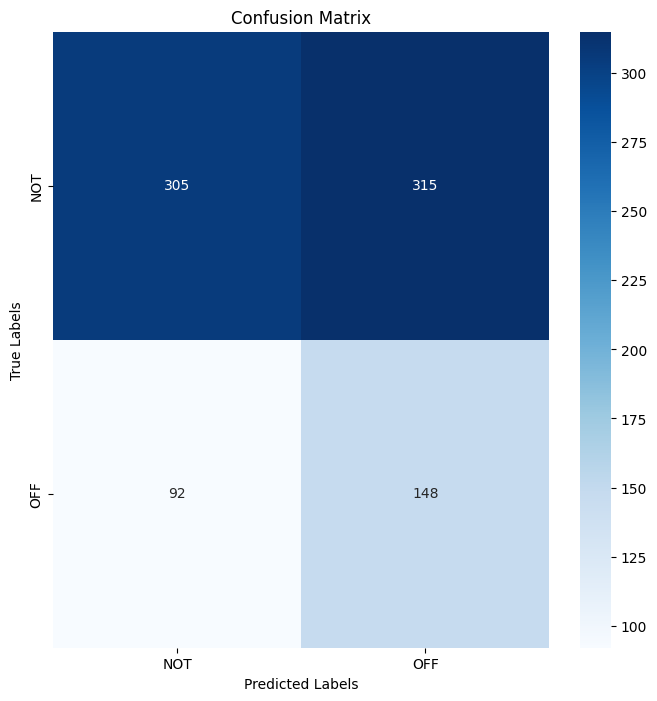

In [ ]:
conf_matrix = confusion_matrix(test_labels_a, y_pred_binary_a)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NOT', 'OFF'], yticklabels=['NOT', 'OFF'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
f1 = f1_score(test_labels_a, y_pred_binary_a)
print(f'F1 Score: {f1}')

F1 Score: 0.42105263157894735


#### Classification Report

In [ ]:
class_report = classification_report(test_labels_a, y_pred_binary_a, target_names=['NOT', 'OFF'])
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         NOT       0.77      0.49      0.60       620
         OFF       0.32      0.62      0.42       240

    accuracy                           0.53       860
   macro avg       0.54      0.55      0.51       860
weighted avg       0.64      0.53      0.55       860



### Subtask b

#### Dataset

In [ ]:
tweets.loc[tweets['subtask_b'].isna(), 'subtask_bn'] = 2
tweets.loc[tweets['subtask_b'] == 'UNT', 'subtask_bn'] = 0
tweets.loc[tweets['subtask_b'] == 'TIN', 'subtask_bn'] = 1
tweets['subtask_bn'] = tweets['subtask_bn'].astype('int')

test_label_b.loc[test_label_b[1] == 'TIN', 'subtask_bn'] = 1
test_label_b.loc[test_label_b[1] == 'UNT', 'subtask_bn'] = 0
test_label_b['subtask_bn'] = test_label_b['subtask_bn'].astype('int')

In [ ]:
x_train_b = tweets.loc[tweets['subtask_bn'] != 2, 'tweet']
x_train_b.head(10)

0                              ask native american take
1                    go home youre drunk maga trump2020
3              someone shouldvetaken piece shit volcano
5                                        liberal kookoo
6                                      oh no tough shit
7     literally talking lol mass shooting like set u...
9     canada doesnt need another cuck already enough...
12    lying corrupt traitor nobody want hear anymore...
19                               gun control kid asking
20    lol throwing bullshit flag nonsense putuporshu...
Name: tweet, dtype: object

In [ ]:
tweets_b = x_train_b.to_list()
tweets_labels_b = tweets.loc[tweets['subtask_bn'] != 2, 'subtask_bn'].to_list()
test_b = test_inst_b['tweet'].to_list()
test_labels_b = test_label_b['subtask_bn'].to_list()

In [ ]:
onehot_repr_train_b=[one_hot(t,voc_size)for t in tweets_b]
onehot_repr_test_b=[one_hot(t,voc_size)for t in test_b]

In [ ]:
embedded_docs_train=pad_sequences(onehot_repr_train_b,padding='pre',maxlen=sent_length)
print(embedded_docs_train)
embedded_docs_test=pad_sequences(onehot_repr_test_b,padding='pre',maxlen=sent_length)
print(embedded_docs_test)

[[  0   0   0 ... 588 138 500]
 [  0   0   0 ... 554 419 620]
 [  0   0   0 ... 693 697 974]
 ...
 [  0   0   0 ... 330 193  25]
 [  0   0   0 ... 566 623 901]
 [  0   0   0 ...   0   0 214]]
[[941 253 488 ... 677 807  64]
 [  0   0  87 ... 752 444  64]
 [  0   0   0 ... 400 640  73]
 ...
 [  0   0   0 ... 738 586  64]
 [  0 384 289 ...  64 992 807]
 [800 637 318 ... 476 100 574]]


In [ ]:
X_b=np.array(embedded_docs_train)
Y_b=np.array(tweets_labels_b)

X_test_b=np.array(embedded_docs_test)
Y_test_b=np.array(test_labels_b)

#### Train-Test Split

In [ ]:
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_b, Y_b, test_size=0.2, random_state=42)

#### Model Creation

In [ ]:
embedding_vector_features=40
model_b=Sequential()
model_b.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model_b.add(Dropout(0.3))
model_b.add(LSTM(100))
model_b.add(Dropout(0.3))
model_b.add(Dense(1,activation='sigmoid'))
model_b.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model_b.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 40)            40000     
                                                                 
 dropout_2 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 96,501
Trainable params: 96,501
Non-trainable params: 0
_________________________________________________________________
None


#### Model Training

In [ ]:
model_b.fit(x_train_b, y_train_b, validation_data=(x_val_b,y_val_b), epochs=10, batch_size=64)

Epoch 1/10
55/55 [==============================] - 17s 247ms/step - loss: 0.4376 - accuracy: 0.8730 - val_loss: 0.3819 - val_accuracy: 0.8727
Epoch 2/10
55/55 [==============================] - 5s 91ms/step - loss: 0.3603 - accuracy: 0.8830 - val_loss: 0.3733 - val_accuracy: 0.8727
Epoch 3/10
55/55 [==============================] - 6s 114ms/step - loss: 0.3371 - accuracy: 0.8830 - val_loss: 0.3638 - val_accuracy: 0.8727
Epoch 4/10
55/55 [==============================] - 3s 47ms/step - loss: 0.3028 - accuracy: 0.8827 - val_loss: 0.3741 - val_accuracy: 0.8727
Epoch 5/10
55/55 [==============================] - 2s 35ms/step - loss: 0.2631 - accuracy: 0.8872 - val_loss: 0.4674 - val_accuracy: 0.8727
Epoch 6/10
55/55 [==============================] - 2s 29ms/step - loss: 0.2351 - accuracy: 0.8957 - val_loss: 0.4667 - val_accuracy: 0.8659
Epoch 7/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2118 - accuracy: 0.9037 - val_loss: 0.5498 - val_accuracy: 0.8727
Epoch 8/10

#### Model Testing

In [ ]:
y_pred=model_b.predict(X_test_b)

8/8 [==============================] - 1s 4ms/step


In [ ]:
#y_pred

In [ ]:
y_pred_binary_b = (y_pred > 0.5).astype(int)

#### Accuracy, Confusion Matrix, and f1 Value

In [ ]:
accuracy_score(Y_test_b,y_pred_binary_b)

0.8291666666666667

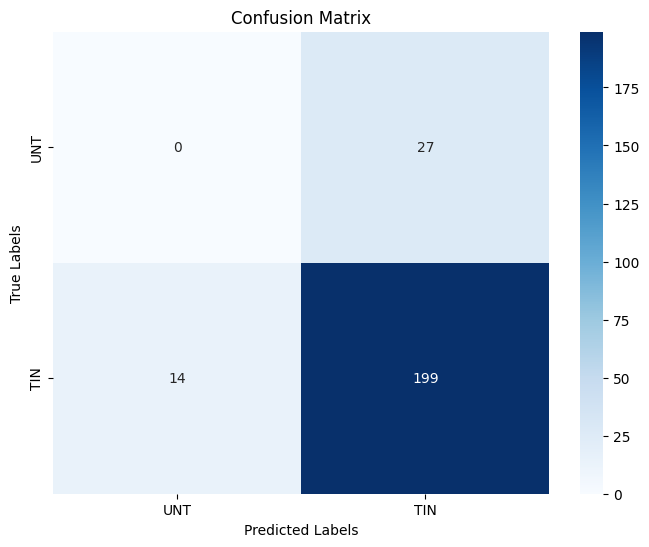

In [ ]:
conf_matrix = confusion_matrix(test_labels_b, y_pred_binary_b)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['UNT', 'TIN'], yticklabels=['UNT', 'TIN'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
f1 = f1_score(test_labels_b, y_pred_binary_b)
print(f'F1 Score: {f1}')

F1 Score: 0.9066059225512528


#### Classification Report

In [ ]:
class_report = classification_report(test_labels_b, y_pred_binary_b, target_names=['UNT', 'TIN'])
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         UNT       0.00      0.00      0.00        27
         TIN       0.88      0.93      0.91       213

    accuracy                           0.83       240
   macro avg       0.44      0.47      0.45       240
weighted avg       0.78      0.83      0.80       240



### Subtask c

#### Dataset

In [ ]:
tweets.loc[tweets['subtask_c'].isna(), 'subtask_cn'] = 3
tweets.loc[tweets['subtask_c'] == 'IND', 'subtask_cn'] = 0
tweets.loc[tweets['subtask_c'] == 'GRP', 'subtask_cn'] = 1
tweets.loc[tweets['subtask_c'] == 'OTH', 'subtask_cn'] = 2
tweets['subtask_cn'] = tweets['subtask_cn'].astype('int')

tweets.info()


test_label_c.loc[test_label_c[1] == 'IND', 'subtask_cn'] = 0
test_label_c.loc[test_label_c[1] == 'GRP', 'subtask_cn'] = 1
test_label_c.loc[test_label_c[1] == 'OTH', 'subtask_cn'] = 2
test_label_c['subtask_cn'] = test_label_c['subtask_cn'].astype('int')

test_label_c.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          13240 non-null  int64 
 1   tweet       13240 non-null  object
 2   subtask_a   13240 non-null  object
 3   subtask_b   4400 non-null   object
 4   subtask_c   3876 non-null   object
 5   count       13240 non-null  int64 
 6   subtask_an  13240 non-null  int64 
 7   subtask_bn  13240 non-null  int64 
 8   subtask_cn  13240 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 931.1+ KB


,0,1,subtask_cn
0,15923,OTH,2
1,60133,GRP,1
2,83681,IND,0
3,65507,OTH,2
4,34263,IND,0
5,49139,IND,0
6,58995,GRP,1
7,88490,IND,0
8,46444,IND,0
9,60587,IND,0


In [ ]:
x_train_c = tweets.loc[tweets['subtask_cn'] != 3, 'tweet']
x_train_c.head(10)

1                    go home youre drunk maga trump2020
5                                        liberal kookoo
7     literally talking lol mass shooting like set u...
9     canada doesnt need another cuck already enough...
12    lying corrupt traitor nobody want hear anymore...
19                               gun control kid asking
20    lol throwing bullshit flag nonsense putuporshu...
22    kind like conservative wan na associate everyo...
23    da fuck going people there men room woman room...
25    tbh day dont like people general dont connect ...
Name: tweet, dtype: object

In [ ]:
tweets_c = x_train_c.to_list()
tweets_labels_c = tweets.loc[tweets['subtask_cn'] != 3, 'subtask_cn'].to_list()
test_c = test_inst_c['tweet'].to_list()
test_labels_c = test_label_c['subtask_cn'].to_list()

In [ ]:
onehot_repr_train_c=[one_hot(t,voc_size)for t in tweets_c]
onehot_repr_test_c=[one_hot(t,voc_size)for t in test_c]

In [ ]:
embedded_docs_train=pad_sequences(onehot_repr_train_c,padding='pre',maxlen=sent_length)
print(embedded_docs_train)
embedded_docs_test=pad_sequences(onehot_repr_test_c,padding='pre',maxlen=sent_length)
print(embedded_docs_test)

[[  0   0   0 ... 554 419 620]
 [  0   0   0 ...   0 303 635]
 [  0   0 521 ... 676 371 354]
 ...
 [  0   0   0 ... 398 941 769]
 [  0   0   0 ... 330 193  25]
 [  0   0   0 ... 566 623 901]]
[[941 253 488 ... 677 807  64]
 [  0   0  87 ... 752 444  64]
 [  0   0   0 ... 400 640  73]
 ...
 [  0   0   0 ... 384 163 739]
 [  0   0   0 ... 738 586  64]
 [  0 384 289 ...  64 992 807]]


In [ ]:
X_c=np.array(embedded_docs_train)
Y_c=np.array(tweets_labels_c)

X_test_c=np.array(embedded_docs_test)
Y_test_c=np.array(test_labels_c)

#### Train-Test Split

In [ ]:
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_c, Y_c, test_size=0.2, random_state=42)

#### Model Creation

In [ ]:
embedding_vector_features=40
model_c=Sequential()
model_c.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model_c.add(Dropout(0.3))
model_c.add(LSTM(100))
model_c.add(Dropout(0.3))
model_c.add(Dense(3,activation='softmax'))
model_c.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model_c.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 40)            40000     
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 96,703
Trainable params: 96,703
Non-trainable params: 0
_________________________________________________________________
None


#### Model Training

In [ ]:
model_c.fit(x_train_c, y_train_c, validation_data=(x_val_c,y_val_c), epochs=10, batch_size=64)

Epoch 1/10
49/49 [==============================] - 21s 357ms/step - loss: 0.9255 - accuracy: 0.6074 - val_loss: 0.8442 - val_accuracy: 0.6456
Epoch 2/10
49/49 [==============================] - 8s 162ms/step - loss: 0.8557 - accuracy: 0.6158 - val_loss: 0.8055 - val_accuracy: 0.6443
Epoch 3/10
49/49 [==============================] - 2s 47ms/step - loss: 0.7914 - accuracy: 0.6610 - val_loss: 0.8074 - val_accuracy: 0.6611
Epoch 4/10
49/49 [==============================] - 2s 43ms/step - loss: 0.7338 - accuracy: 0.6997 - val_loss: 0.8097 - val_accuracy: 0.6765
Epoch 5/10
49/49 [==============================] - 1s 28ms/step - loss: 0.6813 - accuracy: 0.7235 - val_loss: 0.8354 - val_accuracy: 0.6624
Epoch 6/10
49/49 [==============================] - 3s 53ms/step - loss: 0.6339 - accuracy: 0.7474 - val_loss: 0.9038 - val_accuracy: 0.6534
Epoch 7/10
49/49 [==============================] - 2s 42ms/step - loss: 0.5974 - accuracy: 0.7642 - val_loss: 0.9293 - val_accuracy: 0.6443
Epoch 8/10

#### Model Testing

In [ ]:
y_pred=model_c.predict(X_test_c)
y_pred_single_class = np.argmax(y_pred, axis=1)

7/7 [==============================] - 1s 5ms/step


In [ ]:
y_pred_single_class

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 2,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 2, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0,
       0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1])

In [ ]:
y_pred_binary_c = (y_pred_single_class > 0.5).astype(int)

#### Accuracy, Confusion Matrix and f1 Value

In [ ]:
accuracy_score(Y_test_c,y_pred_binary_c)

0.48826291079812206

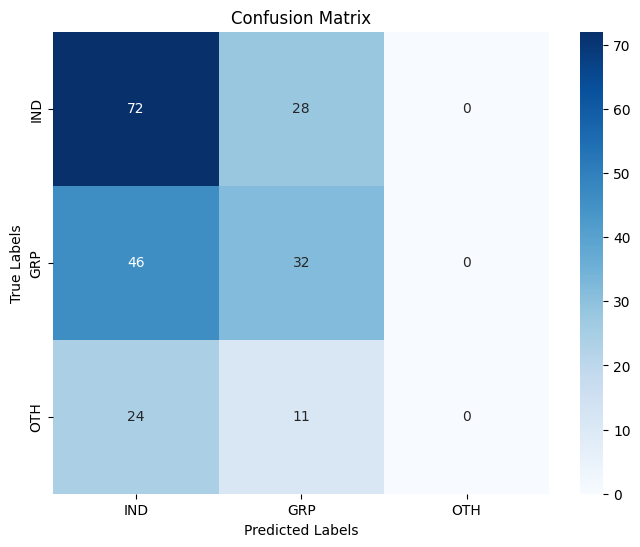

In [ ]:
conf_matrix = confusion_matrix(test_labels_c, y_pred_binary_c)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['IND', 'GRP', 'OTH'], yticklabels=['IND', 'GRP', 'OTH'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
f1 = f1_score(test_labels_c, y_pred_binary_c, average='macro')
print(f'F1 Score: {f1}')

F1 Score: 0.34152384121877716


#### Classification Report

In [ ]:
class_report = classification_report(test_labels_c, y_pred_binary_c, target_names=['IND', 'GRP', 'OTH'])
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         IND       0.51      0.72      0.60       100
         GRP       0.45      0.41      0.43        78
         OTH       0.00      0.00      0.00        35

    accuracy                           0.49       213
   macro avg       0.32      0.38      0.34       213
weighted avg       0.40      0.49      0.44       213



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#GRU

### Subtask a

#### Model Creation

In [ ]:
embedding_vector_features=40
gru_a=Sequential()
gru_a.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
gru_a.add(Dropout(0.3))
gru_a.add(GRU(100))
gru_a.add(Dropout(0.3))
gru_a.add(Dense(1,activation='sigmoid'))
gru_a.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(gru_a.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 40)            40000     
                                                                 
 dropout_6 (Dropout)         (None, 20, 40)            0         
                                                                 
 gru (GRU)                   (None, 100)               42600     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 82,701
Trainable params: 82,701
Non-trainable params: 0
_________________________________________________________________
None


#### Model Training

In [ ]:
gru_a.fit(x_train_a, y_train_a, validation_data=(x_val_a,y_val_a), epochs=10, batch_size=64)

Epoch 1/10
166/166 [==============================] - 32s 158ms/step - loss: 0.6193 - accuracy: 0.6750 - val_loss: 0.6015 - val_accuracy: 0.6847
Epoch 2/10
166/166 [==============================] - 8s 45ms/step - loss: 0.5532 - accuracy: 0.7212 - val_loss: 0.5880 - val_accuracy: 0.6968
Epoch 3/10
166/166 [==============================] - 6s 35ms/step - loss: 0.5346 - accuracy: 0.7358 - val_loss: 0.5897 - val_accuracy: 0.7032
Epoch 4/10
166/166 [==============================] - 5s 33ms/step - loss: 0.5199 - accuracy: 0.7431 - val_loss: 0.6116 - val_accuracy: 0.6941
Epoch 5/10
166/166 [==============================] - 2s 15ms/step - loss: 0.5072 - accuracy: 0.7513 - val_loss: 0.6181 - val_accuracy: 0.6952
Epoch 6/10
166/166 [==============================] - 3s 20ms/step - loss: 0.4981 - accuracy: 0.7553 - val_loss: 0.6259 - val_accuracy: 0.6983
Epoch 7/10
166/166 [==============================] - 3s 19ms/step - loss: 0.4859 - accuracy: 0.7632 - val_loss: 0.6302 - val_accuracy: 0.68

#### Model Testing

In [ ]:
y_pred=gru_a.predict(X_test_a)

27/27 [==============================] - 1s 3ms/step


In [ ]:
y_pred

In [ ]:
y_pred_binary_a = (y_pred > 0.5).astype(int)

#### Accuracy, Confusion Matrix and f1 Score

In [ ]:
accuracy_score(Y_test_a,y_pred_binary_a)

0.541860465116279

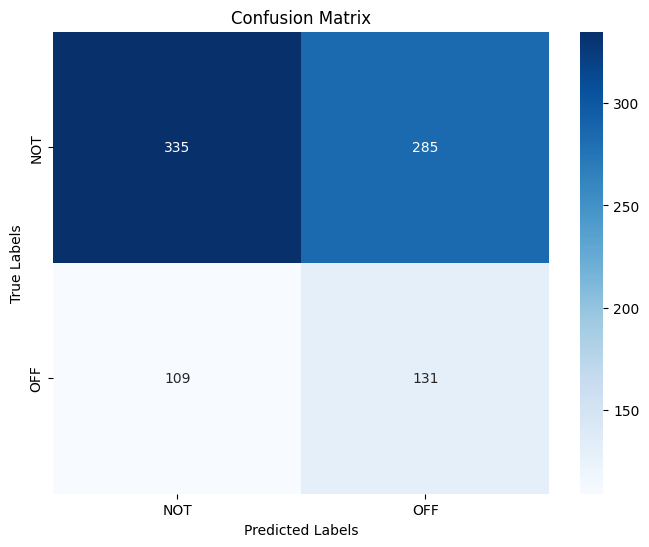

In [ ]:
conf_matrix = confusion_matrix(test_labels_a, y_pred_binary_a)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NOT', 'OFF'], yticklabels=['NOT', 'OFF'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
f1 = f1_score(test_labels_a, y_pred_binary_a)
print(f'F1 Score: {f1}')

F1 Score: 0.399390243902439


#### Classification Report

In [ ]:
class_report = classification_report(test_labels_a, y_pred_binary_a, target_names=['NOT', 'OFF'])
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         NOT       0.75      0.54      0.63       620
         OFF       0.31      0.55      0.40       240

    accuracy                           0.54       860
   macro avg       0.53      0.54      0.51       860
weighted avg       0.63      0.54      0.57       860



### Subtask b

#### Model Creation

In [ ]:
embedding_vector_features=40
gru_b=Sequential()
gru_b.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
gru_b.add(Dropout(0.3))
gru_b.add(GRU(100))
gru_b.add(Dropout(0.3))
gru_b.add(Dense(1,activation='sigmoid'))
gru_b.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(gru_b.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 40)            40000     
                                                                 
 dropout_8 (Dropout)         (None, 20, 40)            0         
                                                                 
 gru_1 (GRU)                 (None, 100)               42600     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 82,701
Trainable params: 82,701
Non-trainable params: 0
_________________________________________________________________
None


#### Model Training

In [ ]:
gru_b.fit(x_train_b, y_train_b, validation_data=(x_val_b,y_val_b), epochs=10, batch_size=64)

Epoch 1/10
55/55 [==============================] - 17s 235ms/step - loss: 0.4402 - accuracy: 0.8750 - val_loss: 0.3806 - val_accuracy: 0.8727
Epoch 2/10
55/55 [==============================] - 7s 136ms/step - loss: 0.3490 - accuracy: 0.8830 - val_loss: 0.3639 - val_accuracy: 0.8727
Epoch 3/10
55/55 [==============================] - 5s 101ms/step - loss: 0.3206 - accuracy: 0.8830 - val_loss: 0.3731 - val_accuracy: 0.8727
Epoch 4/10
55/55 [==============================] - 1s 21ms/step - loss: 0.2855 - accuracy: 0.8844 - val_loss: 0.3912 - val_accuracy: 0.8750
Epoch 5/10
55/55 [==============================] - 1s 20ms/step - loss: 0.2594 - accuracy: 0.8932 - val_loss: 0.4268 - val_accuracy: 0.8670
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2367 - accuracy: 0.8977 - val_loss: 0.4775 - val_accuracy: 0.8659
Epoch 7/10
55/55 [==============================] - 1s 24ms/step - loss: 0.2180 - accuracy: 0.9034 - val_loss: 0.5286 - val_accuracy: 0.8545
Epoch 8/1

#### Model Testing

In [ ]:
y_pred=gru_b.predict(X_test_b)

8/8 [==============================] - 1s 3ms/step


In [ ]:
y_pred_binary_b = (y_pred > 0.5).astype(int)

#### Accuracy, Confusion Matrix, and f1 Value

In [ ]:
accuracy_score(Y_test_b,y_pred_binary_b)

0.8833333333333333

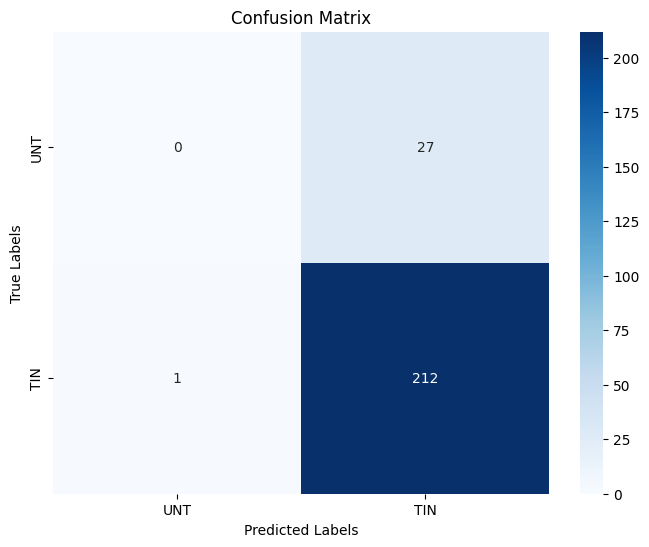

In [ ]:
conf_matrix = confusion_matrix(test_labels_b, y_pred_binary_b)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['UNT', 'TIN'], yticklabels=['UNT', 'TIN'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
f1 = f1_score(test_labels_b, y_pred_binary_b)
print(f'F1 Score: {f1}')

F1 Score: 0.9380530973451326


#### Classification Report

In [ ]:
class_report = classification_report(test_labels_b, y_pred_binary_b, target_names=['UNT', 'TIN'])
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         UNT       0.00      0.00      0.00        27
         TIN       0.89      1.00      0.94       213

    accuracy                           0.88       240
   macro avg       0.44      0.50      0.47       240
weighted avg       0.79      0.88      0.83       240



### Subtask c

#### Model Creation

In [ ]:
embedding_vector_features=40
gru_c=Sequential()
gru_c.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
gru_c.add(Dropout(0.3))
gru_c.add(GRU(100))
gru_c.add(Dropout(0.3))
gru_c.add(Dense(3,activation='softmax'))
gru_c.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(gru_c.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 40)            40000     
                                                                 
 dropout_10 (Dropout)        (None, 20, 40)            0         
                                                                 
 gru_2 (GRU)                 (None, 100)               42600     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 303       
                                                                 
Total params: 82,903
Trainable params: 82,903
Non-trainable params: 0
_________________________________________________________________
None


#### Model Training

In [ ]:
gru_c.fit(x_train_c, y_train_c, validation_data=(x_val_c,y_val_c), epochs=10, batch_size=64)

Epoch 1/10
49/49 [==============================] - 18s 306ms/step - loss: 0.9286 - accuracy: 0.6094 - val_loss: 0.8487 - val_accuracy: 0.6456
Epoch 2/10
49/49 [==============================] - 5s 101ms/step - loss: 0.8478 - accuracy: 0.6190 - val_loss: 0.8053 - val_accuracy: 0.6443
Epoch 3/10
49/49 [==============================] - 2s 39ms/step - loss: 0.7675 - accuracy: 0.6668 - val_loss: 0.8527 - val_accuracy: 0.6186
Epoch 4/10
49/49 [==============================] - 5s 98ms/step - loss: 0.7075 - accuracy: 0.7065 - val_loss: 0.8266 - val_accuracy: 0.6456
Epoch 5/10
49/49 [==============================] - 1s 28ms/step - loss: 0.6482 - accuracy: 0.7361 - val_loss: 0.8692 - val_accuracy: 0.6701
Epoch 6/10
49/49 [==============================] - 1s 22ms/step - loss: 0.6025 - accuracy: 0.7519 - val_loss: 0.9167 - val_accuracy: 0.6289
Epoch 7/10
49/49 [==============================] - 1s 18ms/step - loss: 0.5575 - accuracy: 0.7755 - val_loss: 0.9955 - val_accuracy: 0.6495
Epoch 8/10

#### Model Testing

In [ ]:
y_pred=gru_c.predict(X_test_c)
y_pred_single_class = np.argmax(y_pred, axis=1)

7/7 [==============================] - 0s 3ms/step


In [ ]:
y_pred_single_class

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 0,
       0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 2,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1])

In [ ]:
y_pred_binary_c = (y_pred_single_class > 0.5).astype(int)

#### Accuracy, Confusion Matrix, and f1 Value

In [ ]:
accuracy_score(Y_test_c,y_pred_binary_c)

0.4460093896713615

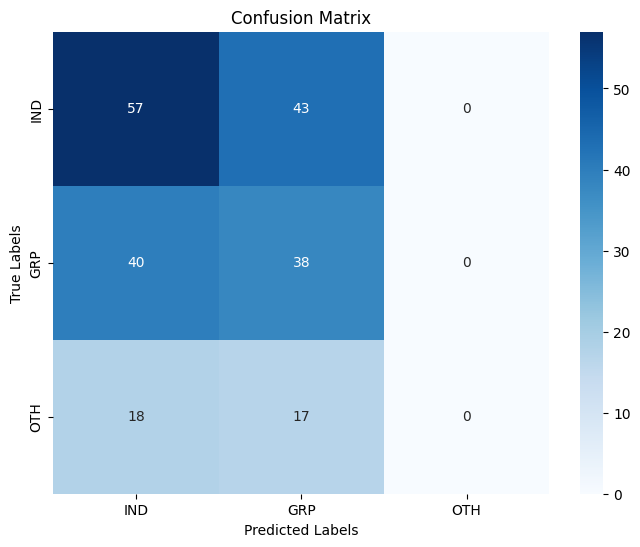

In [ ]:
conf_matrix = confusion_matrix(test_labels_c, y_pred_binary_c)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['IND', 'GRP', 'OTH'], yticklabels=['IND', 'GRP', 'OTH'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
f1 = f1_score(test_labels_c, y_pred_binary_c, average='macro')
print(f'F1 Score: {f1}')

F1 Score: 0.3206835799859055


#### Classification Report

In [ ]:
class_report = classification_report(test_labels_c, y_pred_binary_c, target_names=['IND', 'GRP', 'OTH'])
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         IND       0.50      0.57      0.53       100
         GRP       0.39      0.49      0.43        78
         OTH       0.00      0.00      0.00        35

    accuracy                           0.45       213
   macro avg       0.29      0.35      0.32       213
weighted avg       0.37      0.45      0.41       213



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#ROBERTA

### Subtask a

#### Train Dataset

In [ ]:
tweets.loc[tweets['subtask_a'] == 'OFF', 'subtask_an'] = 1
tweets.loc[tweets['subtask_a'] == 'NOT', 'subtask_an'] = 0
tweets['subtask_an'] = tweets['subtask_an'].astype('int')

tweets.head(10)

,id,tweet,subtask_a,subtask_b,subtask_c,count,subtask_an,subtask_bn,subtask_cn
0,86426,ask native american take,OFF,UNT,NaN,4,1,0,3
1,90194,go home youre drunk maga trump2020,OFF,TIN,IND,6,1,1,0
2,16820,amazon investigating chinese employee selling ...,NOT,NaN,NaN,18,0,2,3
3,62688,someone shouldvetaken piece shit volcano,OFF,UNT,NaN,5,1,0,3
4,43605,obama wanted liberal illegals move red state,NOT,NaN,NaN,7,0,2,3
5,97670,liberal kookoo,OFF,TIN,OTH,2,1,1,2
6,77444,oh no tough shit,OFF,UNT,NaN,4,1,0,3
7,52415,literally talking lol mass shooting like set u...,OFF,TIN,GRP,18,1,1,1
8,45157,buy icecream,NOT,NaN,NaN,2,0,2,3
9,13384,canada doesnt need another cuck already enough...,OFF,TIN,IND,14,1,1,0


In [ ]:
tweets_a = tweets['tweet'].to_list()
tweets_labels_a = tweets['subtask_an'].to_list()

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(tweets_a, tweets_labels_a, test_size=0.2, random_state=42)

In [ ]:
# Load the pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-offensive")

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(100).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(32)

#### Test Dataset

In [ ]:
test_label_a.loc[test_label_a[1] == 'OFF', 'subtask_an'] = 1
test_label_a.loc[test_label_a[1] == 'NOT', 'subtask_an'] = 0
test_label_a['subtask_an'] = test_label_a['subtask_an'].astype('int')

test_label_a.head(10)

,0,1,subtask_an
0,15923,OFF,1
1,27014,NOT,0
2,30530,NOT,0
3,13876,NOT,0
4,60133,OFF,1
5,83681,OFF,1
6,96874,NOT,0
7,65507,OFF,1
8,78910,NOT,0
9,46363,NOT,0


In [ ]:
test_a = test_inst_a['tweet'].to_list()

test_labels_a = test_label_a['subtask_an'].to_list()

In [ ]:
test_encodings = tokenizer(test_a, truncation=True, padding=True, max_length=128)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels_a)).batch(32)

#### Load Pretrained Model

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-offensive", num_labels=2)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


#### Testing

In [ ]:
predictions = model.predict(test_dataset)
predicted_labels_a = tf.argmax(predictions.logits, axis=1).numpy()

27/27 [==============================] - 13s 247ms/step


#### Accuracy, Confusion Matrix, and f1 Score

In [ ]:
accuracy = accuracy_score(test_labels_a, predicted_labels_a)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8581


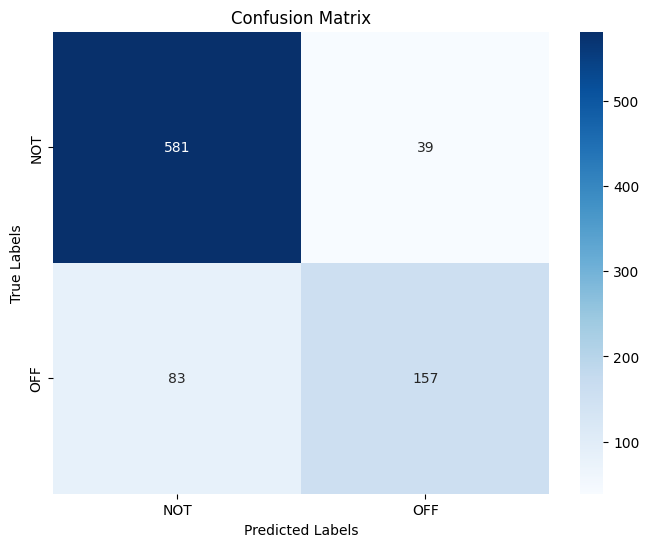

In [ ]:
conf_matrix = confusion_matrix(test_labels_a, predicted_labels_a)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NOT', 'OFF'], yticklabels=['NOT', 'OFF'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
f1 = f1_score(test_labels_a, predicted_labels_a)
print(f'F1 Score: {f1}')

F1 Score: 0.720183486238532


#### Classification Report

In [ ]:
class_report = classification_report(test_labels_a, predicted_labels_a, target_names=['NOT', 'OFF'])
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         NOT       0.88      0.94      0.90       620
         OFF       0.80      0.65      0.72       240

    accuracy                           0.86       860
   macro avg       0.84      0.80      0.81       860
weighted avg       0.85      0.86      0.85       860



### Subtask b

#### Train Dataset

In [ ]:
tweets.loc[tweets['subtask_b'].isna(), 'subtask_bn'] = 2
tweets.loc[tweets['subtask_b'] == 'UNT', 'subtask_bn'] = 0
tweets.loc[tweets['subtask_b'] == 'TIN', 'subtask_bn'] = 1
tweets['subtask_bn'] = tweets['subtask_bn'].astype('int')

tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          13240 non-null  int64 
 1   tweet       13240 non-null  object
 2   subtask_a   13240 non-null  object
 3   subtask_b   4400 non-null   object
 4   subtask_c   3876 non-null   object
 5   count       13240 non-null  int64 
 6   subtask_an  13240 non-null  int64 
 7   subtask_bn  13240 non-null  int64 
 8   subtask_cn  13240 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 931.1+ KB


In [ ]:
x_train_b = tweets.loc[tweets['subtask_bn'] != 2, 'tweet']
x_train_b.head(10)

0                              ask native american take
1                    go home youre drunk maga trump2020
3              someone shouldvetaken piece shit volcano
5                                        liberal kookoo
6                                      oh no tough shit
7     literally talking lol mass shooting like set u...
9     canada doesnt need another cuck already enough...
12    lying corrupt traitor nobody want hear anymore...
19                               gun control kid asking
20    lol throwing bullshit flag nonsense putuporshu...
Name: tweet, dtype: object

In [ ]:
tweets_b = x_train_b.to_list()

tweets_labels_b = tweets.loc[tweets['subtask_bn'] != 2, 'subtask_bn'].to_list()

print(len(tweets_b))
len(tweets_labels_b)

4400


4400

In [ ]:
train_texts_b, val_texts_b, train_labels_b, val_labels_b = train_test_split(tweets_b, tweets_labels_b, test_size=0.2, random_state=42)

In [ ]:
train_encodings_b = tokenizer(train_texts_b, truncation=True, padding=True, max_length=128)
val_encodings_b = tokenizer(val_texts_b, truncation=True, padding=True, max_length=128)

In [ ]:
train_dataset_b = tf.data.Dataset.from_tensor_slices((dict(train_encodings_b), train_labels_b)).shuffle(100).batch(32)
val_dataset_b = tf.data.Dataset.from_tensor_slices((dict(val_encodings_b), val_labels_b)).batch(32)

#### Test Dataset

In [ ]:
test_label_b.loc[test_label_b[1] == 'TIN', 'subtask_bn'] = 1
test_label_b.loc[test_label_b[1] == 'UNT', 'subtask_bn'] = 0
test_label_b['subtask_bn'] = test_label_b['subtask_bn'].astype('int')

test_label_b.head(10)

,0,1,subtask_bn
0,15923,TIN,1
1,60133,TIN,1
2,83681,TIN,1
3,65507,TIN,1
4,12588,UNT,0
5,34263,TIN,1
6,49139,TIN,1
7,58995,TIN,1
8,88490,TIN,1
9,46444,TIN,1


In [ ]:
test_b = test_inst_b['tweet'].to_list()

test_labels_b = test_label_b['subtask_bn'].to_list()

In [ ]:
test_encodings_b = tokenizer(test_b, truncation=True, padding=True, max_length=128)
test_dataset_b = tf.data.Dataset.from_tensor_slices((dict(test_encodings_b), test_labels_b)).batch(32)

#### Fine-Tuned Model

In [ ]:
model_b = TFAutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-offensive", num_labels=2, ignore_mismatched_sizes=True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
# Set up training configuration
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # binary classification
metrics = ['accuracy']

In [ ]:
model_b.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#### Training

In [ ]:
num_epochs = 5  # Adjust as needed
model_b.fit(train_dataset_b, epochs=num_epochs, batch_size=32, validation_data=val_dataset_b)

Epoch 1/5
110/110 [==============================] - 169s 804ms/step - loss: 0.3704 - accuracy: 0.8744 - val_loss: 0.3548 - val_accuracy: 0.8727
Epoch 2/5
110/110 [==============================] - 66s 597ms/step - loss: 0.3325 - accuracy: 0.8821 - val_loss: 0.3436 - val_accuracy: 0.8727
Epoch 3/5
110/110 [==============================] - 56s 509ms/step - loss: 0.3061 - accuracy: 0.8866 - val_loss: 0.3599 - val_accuracy: 0.8716
Epoch 4/5
110/110 [==============================] - 58s 524ms/step - loss: 0.2600 - accuracy: 0.9003 - val_loss: 0.4028 - val_accuracy: 0.8375
Epoch 5/5
110/110 [==============================] - 54s 491ms/step - loss: 0.1998 - accuracy: 0.9230 - val_loss: 0.4914 - val_accuracy: 0.8375


#### Testing



In [ ]:
predictions = model_b.predict(test_dataset_b)
predicted_labels_b = tf.argmax(predictions.logits, axis=1).numpy()

8/8 [==============================] - 6s 187ms/step


#### Accuracy, Confusion Matrix, and f1 Score

In [ ]:
accuracy = accuracy_score(test_labels_b, predicted_labels_b)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8833


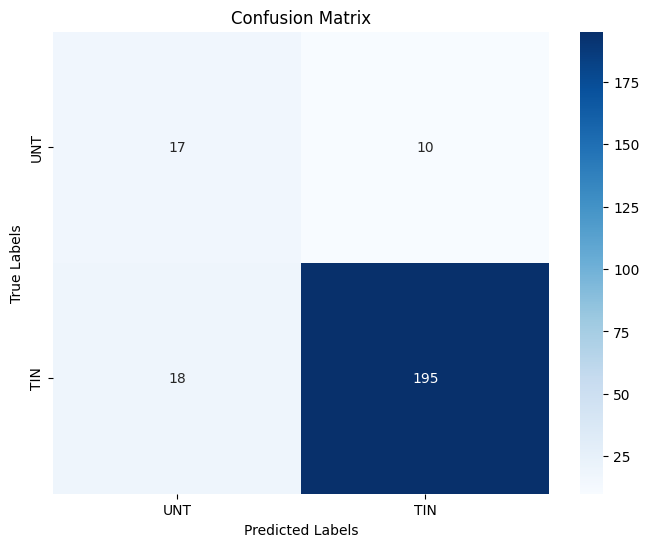

In [ ]:
conf_matrix = confusion_matrix(test_labels_b, predicted_labels_b)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['UNT', 'TIN'], yticklabels=['UNT', 'TIN'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
f1 = f1_score(test_labels_b, predicted_labels_b)
print(f'F1 Score: {f1}')

F1 Score: 0.9330143540669856


#### Classification Report

In [ ]:
class_report = classification_report(test_labels_b, predicted_labels_b, target_names=['UNT', 'TIN'])
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         UNT       0.49      0.63      0.55        27
         TIN       0.95      0.92      0.93       213

    accuracy                           0.88       240
   macro avg       0.72      0.77      0.74       240
weighted avg       0.90      0.88      0.89       240



### Subtask c

#### Train Dataset

In [ ]:
tweets.loc[tweets['subtask_c'].isna(), 'subtask_cn'] = 3
tweets.loc[tweets['subtask_c'] == 'IND', 'subtask_cn'] = 0
tweets.loc[tweets['subtask_c'] == 'GRP', 'subtask_cn'] = 1
tweets.loc[tweets['subtask_c'] == 'OTH', 'subtask_cn'] = 2
tweets['subtask_cn'] = tweets['subtask_cn'].astype('int')

tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          13240 non-null  int64 
 1   tweet       13240 non-null  object
 2   subtask_a   13240 non-null  object
 3   subtask_b   4400 non-null   object
 4   subtask_c   3876 non-null   object
 5   count       13240 non-null  int64 
 6   subtask_an  13240 non-null  int64 
 7   subtask_bn  13240 non-null  int64 
 8   subtask_cn  13240 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 931.1+ KB


In [ ]:
x_train_c = tweets.loc[tweets['subtask_cn'] != 3, 'tweet']
x_train_c.head(10)

1                    go home youre drunk maga trump2020
5                                        liberal kookoo
7     literally talking lol mass shooting like set u...
9     canada doesnt need another cuck already enough...
12    lying corrupt traitor nobody want hear anymore...
19                               gun control kid asking
20    lol throwing bullshit flag nonsense putuporshu...
22    kind like conservative wan na associate everyo...
23    da fuck going people there men room woman room...
25    tbh day dont like people general dont connect ...
Name: tweet, dtype: object

In [ ]:
tweets_c = x_train_c.to_list()
tweets_labels_c = tweets.loc[tweets['subtask_cn'] != 3, 'subtask_cn'].to_list()
print(len(tweets_c))
len(tweets_labels_c)

3876


3876

In [ ]:
train_texts_c, val_texts_c, train_labels_c, val_labels_c = train_test_split(tweets_c, tweets_labels_c, test_size=0.2, random_state=42)

In [ ]:
train_encodings_c = tokenizer(train_texts_c, truncation=True, padding=True, max_length=128)
val_encodings_c = tokenizer(val_texts_c, truncation=True, padding=True, max_length=128)

In [ ]:
train_dataset_c = tf.data.Dataset.from_tensor_slices((dict(train_encodings_c), train_labels_c)).shuffle(100).batch(32)
val_dataset_c = tf.data.Dataset.from_tensor_slices((dict(val_encodings_c), val_labels_c)).batch(32)

#### Test Dataset

In [ ]:
test_label_c.loc[test_label_c[1] == 'IND', 'subtask_cn'] = 0
test_label_c.loc[test_label_c[1] == 'GRP', 'subtask_cn'] = 1
test_label_c.loc[test_label_c[1] == 'OTH', 'subtask_cn'] = 2
test_label_c['subtask_cn'] = test_label_c['subtask_cn'].astype('int')

test_label_c.head(10)

,0,1,subtask_cn
0,15923,OTH,2
1,60133,GRP,1
2,83681,IND,0
3,65507,OTH,2
4,34263,IND,0
5,49139,IND,0
6,58995,GRP,1
7,88490,IND,0
8,46444,IND,0
9,60587,IND,0


In [ ]:
test_c = test_inst_c['tweet'].to_list()
test_labels_c = test_label_c['subtask_cn'].to_list()

In [ ]:
test_encodings_c = tokenizer(test_c, truncation=True, padding=True, max_length=128)
test_dataset_c = tf.data.Dataset.from_tensor_slices((dict(test_encodings_c), test_labels_c)).batch(32)

#### Fine-tuned model

In [ ]:
model_c = TFAutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-offensive", num_labels=3, ignore_mismatched_sizes=True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some weights of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive and are newly initialized because the shapes did not match:
- classifier/out_proj/kernel:0: found shape (768, 2) in the checkpoint and (768, 3) in the model instantiated
- classifier/out_proj/bias:0: found shape (2,) in the checkpoint and (3,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set up training configuration
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # binary classification
metrics = ['accuracy']

In [ ]:
model_c.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#### Training

In [ ]:
num_epochs = 5  # Adjust as needed
model_c.fit(train_dataset_c, epochs=num_epochs, batch_size=32, validation_data=val_dataset_c)

Epoch 1/5
97/97 [==============================] - 106s 562ms/step - loss: 0.8581 - accuracy: 0.6258 - val_loss: 0.7400 - val_accuracy: 0.6959
Epoch 2/5
97/97 [==============================] - 45s 460ms/step - loss: 0.7367 - accuracy: 0.6997 - val_loss: 0.7213 - val_accuracy: 0.6985
Epoch 3/5
97/97 [==============================] - 45s 460ms/step - loss: 0.6599 - accuracy: 0.7319 - val_loss: 0.7414 - val_accuracy: 0.6946
Epoch 4/5
97/97 [==============================] - 45s 463ms/step - loss: 0.5563 - accuracy: 0.7806 - val_loss: 0.8103 - val_accuracy: 0.6933
Epoch 5/5
97/97 [==============================] - 45s 463ms/step - loss: 0.4662 - accuracy: 0.8239 - val_loss: 0.8812 - val_accuracy: 0.6972


#### Testing

In [ ]:
predictions = model_c.predict(test_dataset_c)
predicted_labels_c = tf.argmax(predictions.logits, axis=1).numpy()

7/7 [==============================] - 5s 197ms/step


#### Accuracy, Confusion Matrix, and f1 Score

In [ ]:
accuracy = accuracy_score(test_labels_c, predicted_labels_c)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6808


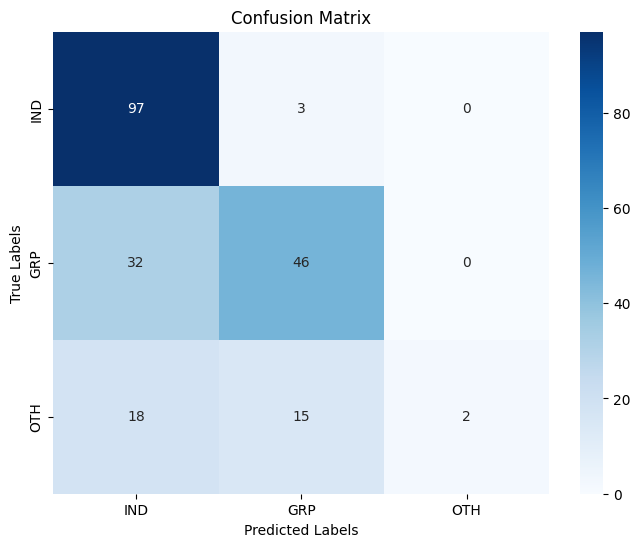

In [ ]:
conf_matrix = confusion_matrix(test_labels_c, predicted_labels_c)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['IND', 'GRP', 'OTH'], yticklabels=['IND', 'GRP', 'OTH'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
f1 = f1_score(test_labels_c, predicted_labels_c, average='macro')
print(f'F1 Score: {f1}')

F1 Score: 0.513806844422115


#### Classification Report

In [ ]:
class_report = classification_report(test_labels_c, predicted_labels_c, target_names=['IND', 'GRP', 'OTH'])
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         IND       0.66      0.97      0.79       100
         GRP       0.72      0.59      0.65        78
         OTH       1.00      0.06      0.11        35

    accuracy                           0.68       213
   macro avg       0.79      0.54      0.51       213
weighted avg       0.74      0.68      0.62       213

